# Image Classifier Training


## Setup

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Download Datasets

Downloads PKLot, CNR-Park and CNR-EXT Datasets for training

In [ ]:
%cd /content
%mkdir -p datasets/{processed,source}

!wget http://www.inf.ufpr.br/vri/databases/PKLot.tar.gz
!wget http://cnrpark.it/dataset/CNR-EXT-Patches-150x150.zip
!wget http://cnrpark.it/dataset/CNRPark-Patches-150x150.zip

!tar -xvzf /content/PKLot.tar.gz -C /content/datasets/source
!unzip /content/CNR-EXT-Patches-150x150.zip -d /content/datasets/source/CNR-EXT-Patches-150x150
!unzip /content/CNRPark-Patches-150x150.zip -d /content/datasets/source/CNRPark-Patches-150x150

!rm -rf /content/PKLot.tar.gz
!rm -rf /content/CNR-EXT-Patches-150x150.zip
!rm -rf /content/CNRPark-Patches-150x150.zip

## Copy images
Copy images according to their folder according to their class

In [ ]:
import os
import re
from shutil import copyfile
import math
import random

CNR_EXT_PATH = '/content/datasets/source/CNR-EXT-Patches-150x150'
CNR_PARK_PATH = '/content/datasets/source/CNRPark-Patches-150x150'
PKLOT_PATH = '/content/datasets/source/PKLot'

DESTINATION = '/content/datasets/processed'

EMPTY_DIR = os.path.join(DESTINATION, 'empty')
OCCUPIED_DIR = os.path.join(DESTINATION, 'occupied')

def setup_folders():
    if not os.path.exists(EMPTY_DIR):
        os.makedirs(EMPTY_DIR)
    if not os.path.exists(OCCUPIED_DIR):
        os.makedirs(OCCUPIED_DIR)

def copy_images(source_dir, image_class):
    # create list of all images in dir
    image_list = [f for f in os.listdir(source_dir)
        if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg|.jpeg|.png)$', f)]

    for filename in image_list:
        if os.path.isfile(os.path.join(source_dir, filename)):
            if image_class == 0:
                copyfile(
                    os.path.join(source_dir, filename),
                    os.path.join(EMPTY_DIR, filename)
                )
            elif image_class == 1:
                copyfile(
                    os.path.join(source_dir, filename),
                    os.path.join(OCCUPIED_DIR, filename)
                )

def copy_cnr_park(path):
    print('Copying CNR Park Dataset...')
    for camera in os.listdir(path):
        if camera.startswith('.'): continue # ignore hidden files
        camera_path = os.path.join(path, camera)
        for image_dir in os.listdir(camera_path):
            if image_dir.startswith('.'): continue # ignore hidden files
            dir = os.path.join(camera_path, image_dir)
            if image_dir == 'busy':
                print('Copying ' + dir)
                copy_images(dir, 1)
            if image_dir == 'free':
                print('Copying ' + dir)
                copy_images(dir, 0)
    print('Finished')

def copy_pklot(path):
    print('Copying PKLot Dataset...')
    patches_path = os.path.join(path, 'PKLotSegmented')

    for camera in os.listdir(patches_path):
        if camera.startswith('.'): continue # ignore hidden files
        camera_dir = os.path.join(patches_path, camera)

        for weather in os.listdir(camera_dir):
            if weather.startswith('.'): continue # ignore hidden files
            weather_dir = os.path.join(camera_dir, weather)

            for date in os.listdir(weather_dir):
                if date.startswith('.'): continue # ignore hidden files
                date_dir = os.path.join(weather_dir, date)

                for image_dir in os.listdir(date_dir):
                    if image_dir.startswith('.'): continue # ignore hidden files
                    dir = os.path.join(date_dir, image_dir)
                    if image_dir == 'Occupied':
                        print('Copying ' + dir)
                        copy_images(dir, 1)
                    if image_dir == 'Empty':
                        print('Copying ' + dir)
                        copy_images(dir, 0)
    print('Finished')

def copy_cnr_ext(path):
    print('Copying CNR EXT Dataset...')

    labels_path = os.path.join(path, 'LABELS/all.txt')
    labels_file = open(labels_path, 'r')
    labels = labels_file.readlines()

    for label in labels:
        file = label.strip().split()[0]
        image_class = label.strip().split()[1]
        file_name = os.path.basename(file)
        image_path = os.path.join(path, 'PATCHES/' + file)

        if os.path.isfile(image_path):
            if image_class == '0':
                copyfile(
                    image_path,
                    os.path.join(EMPTY_DIR, file_name)
                )
            elif label == '1':
                copyfile(
                    image_path,
                    os.path.join(OCCUPIED_DIR, file_name)
                )

    print('Finished')

setup_folders()
copy_cnr_park(CNR_PARK_PATH)
copy_pklot(PKLOT_PATH)
copy_cnr_ext(CNR_EXT_PATH)


## Select the TF2 model

In [4]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


## Set up the dataset

Resize images, split dataset into 0.25 validation and 0.75 training

In [5]:
data_dir = '/content/datasets/processed'

In [6]:
datagen_kwargs = dict(rescale=1./255, validation_split=.25)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 193522 images belonging to 2 classes.
Found 580571 images belonging to 2 classes.


## Defining the model

Put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

Enable fine-tuning to train params of feature extractor.

In [7]:
do_fine_tuning = True #@param {type:"boolean"}

In [8]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


## Training the model

In [9]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [10]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/3
    2/18142 [..............................] - ETA: 47:23 - loss: 0.7769 - accuracy: 0.6250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1002s vs `on_train_batch_end` time: 0.2117s). Check your callbacks.


18142/18142 [==============================] - 6122s 337ms/step - loss: 0.2843 - accuracy: 0.9986 - val_loss: 0.2805 - val_accuracy: 0.9984
Epoch 2/3
18142/18142 [==============================] - 6209s 342ms/step - loss: 0.2751 - accuracy: 0.9996 - val_loss: 0.2750 - val_accuracy: 0.9983
Epoch 3/3
18142/18142 [==============================] - 6144s 339ms/step - loss: 0.2694 - accuracy: 0.9997 - val_loss: 0.2692 - val_accuracy: 0.9987


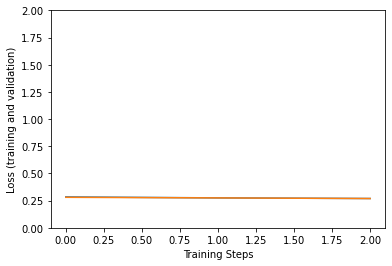

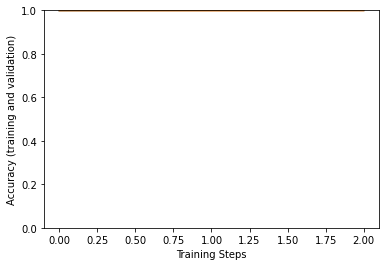

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])


Save trained model for deployment to TF Serving or TF Lite (on mobile)

In [12]:
saved_model_path = "/content/park_mobilenet_v2_100_224"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /content/park_mobilenet_v2_100_224/assets


INFO:tensorflow:Assets written to: /content/park_mobilenet_v2_100_224/assets


In [13]:
%cd /content
!tar -cf park_mobilenet_v2_100_224.tar park_mobilenet_v2_100_224/

/content


## Convert for TensorFlow Lite

In [14]:
optimize_lite_model = True  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 0  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("/content/park_mobilenet_v2_100_224_lite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote optimized TFLite model of 2390240 bytes.


In [15]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [16]:
num_eval_examples = 200 
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 200 of 200 examples (100%).
TF Lite model is accurate on 200 of 200 examples (100%).
